In [53]:
import pandas as pd
import os
import numpy as np
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import scipy
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [4]:
df = pd.read_csv('./dataset/parkinsons.data')

In [6]:
df.columns

Index(['name', 'MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
       'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
       'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'status', 'RPDE', 'DFA',
       'spread1', 'spread2', 'D2', 'PPE'],
      dtype='object')

In [7]:
df.info() #no null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    float64
 1

In [9]:
df.isnull().sum()

name                0
MDVP:Fo(Hz)         0
MDVP:Fhi(Hz)        0
MDVP:Flo(Hz)        0
MDVP:Jitter(%)      0
MDVP:Jitter(Abs)    0
MDVP:RAP            0
MDVP:PPQ            0
Jitter:DDP          0
MDVP:Shimmer        0
MDVP:Shimmer(dB)    0
Shimmer:APQ3        0
Shimmer:APQ5        0
MDVP:APQ            0
Shimmer:DDA         0
NHR                 0
HNR                 0
status              0
RPDE                0
DFA                 0
spread1             0
spread2             0
D2                  0
PPE                 0
dtype: int64

In [17]:
df_analysis = df.loc[:, ~df.columns.isin(['name','status'])]

In [18]:
df_analysis.describe()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,...,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,154.228641,197.104918,116.324631,0.006220,0.000044,0.003306,0.003446,0.009920,0.029709,0.282251,...,0.024081,0.046993,0.024847,21.885974,0.498536,0.718099,-5.684397,0.226510,2.381826,0.206552
std,41.390065,91.491548,43.521413,0.004848,0.000035,0.002968,0.002759,0.008903,0.018857,0.194877,...,0.016947,0.030459,0.040418,4.425764,0.103942,0.055336,1.090208,0.083406,0.382799,0.090119
min,88.333000,102.145000,65.476000,0.001680,0.000007,0.000680,0.000920,0.002040,0.009540,0.085000,...,0.007190,0.013640,0.000650,8.441000,0.256570,0.574282,-7.964984,0.006274,1.423287,0.044539
25%,117.572000,134.862500,84.291000,0.003460,0.000020,0.001660,0.001860,0.004985,0.016505,0.148500,...,0.013080,0.024735,0.005925,19.198000,0.421306,0.674758,-6.450096,0.174351,2.099125,0.137451
50%,148.790000,175.829000,104.315000,0.004940,0.000030,0.002500,0.002690,0.007490,0.022970,0.221000,...,0.018260,0.038360,0.011660,22.085000,0.495954,0.722254,-5.720868,0.218885,2.361532,0.194052
75%,182.769000,224.205500,140.018500,0.007365,0.000060,0.003835,0.003955,0.011505,0.037885,0.350000,...,0.029400,0.060795,0.025640,25.075500,0.587562,0.761881,-5.046192,0.279234,2.636456,0.252980
max,260.105000,592.030000,239.170000,0.033160,0.000260,0.021440,0.019580,0.064330,0.119080,1.302000,...,0.137780,0.169420,0.314820,33.047000,0.685151,0.825288,-2.434031,0.450493,3.671155,0.527367


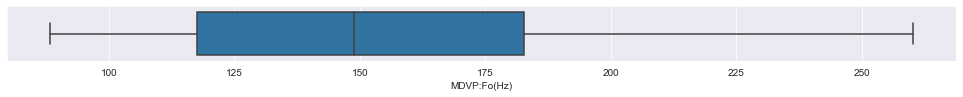

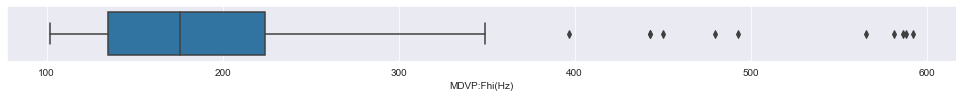

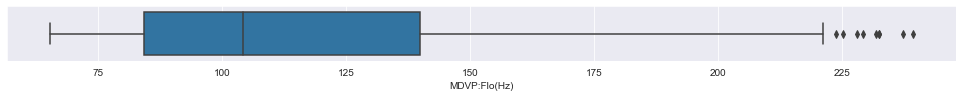

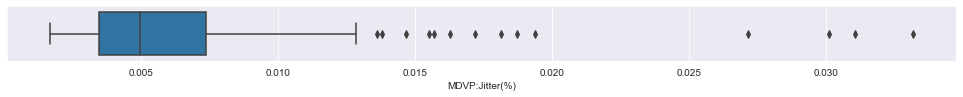

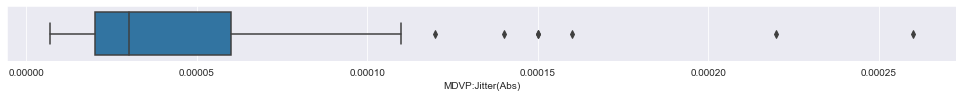

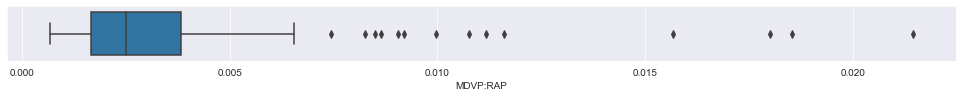

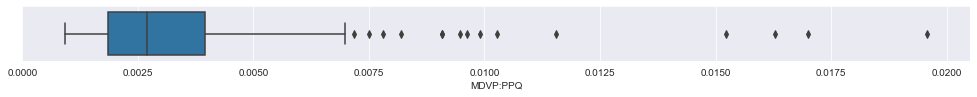

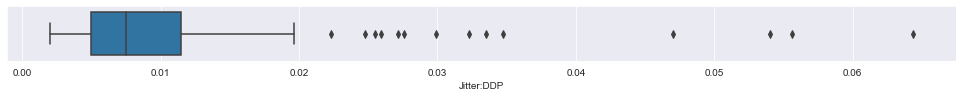

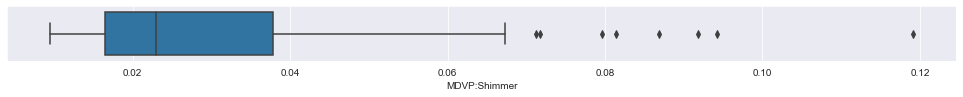

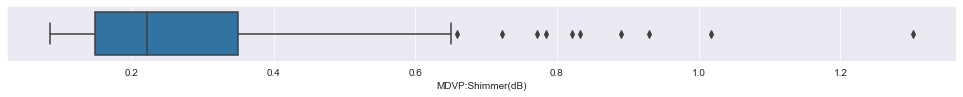

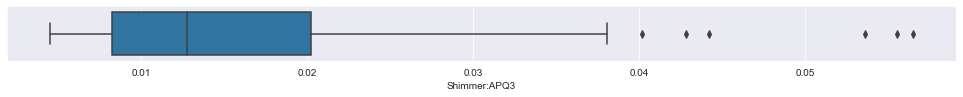

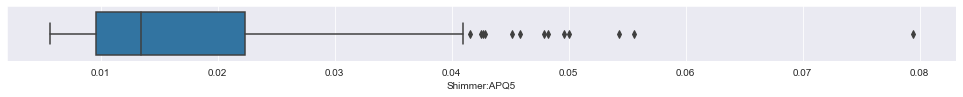

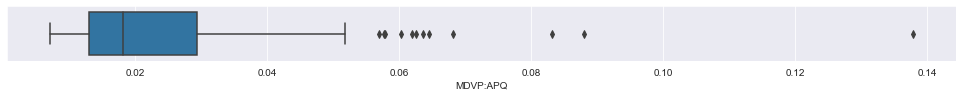

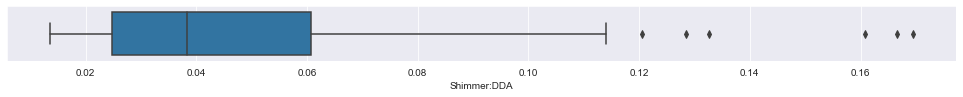

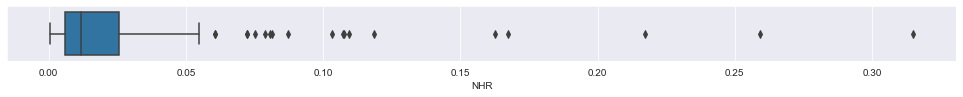

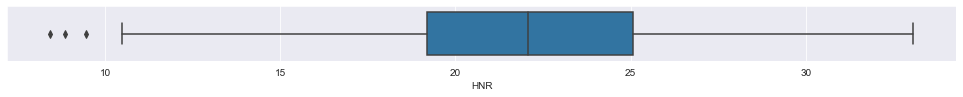

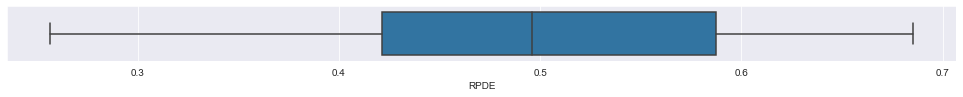

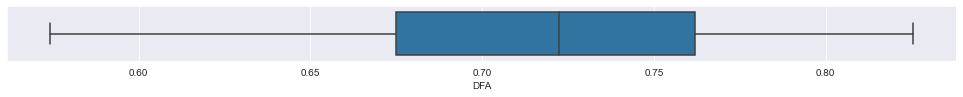

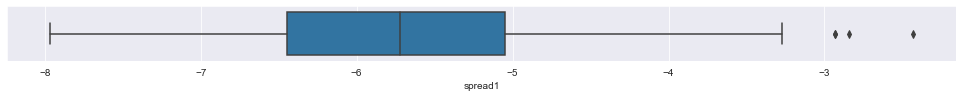

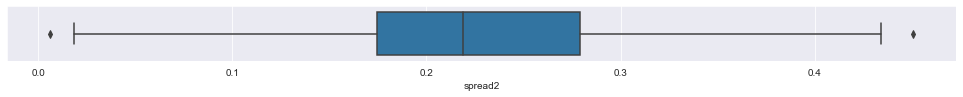

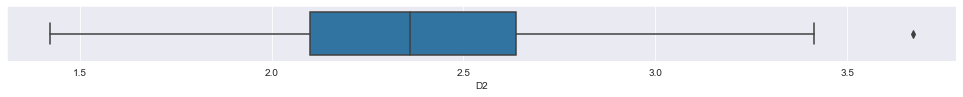

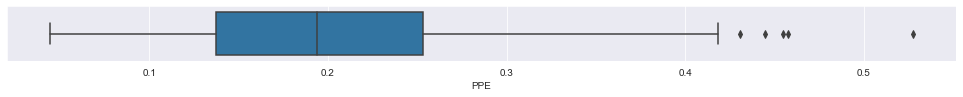

In [44]:
# df_analysis.plot(kind='box',figsize=(15,10)
sns.set_style("darkgrid")
df1=df_analysis.select_dtypes(exclude=['object'])
for column in df1.columns:
    plt.figure(figsize=(17,1))
    sns.boxplot(data=df1, x=column)
    

Plots for column: MDVP:Fo(Hz)


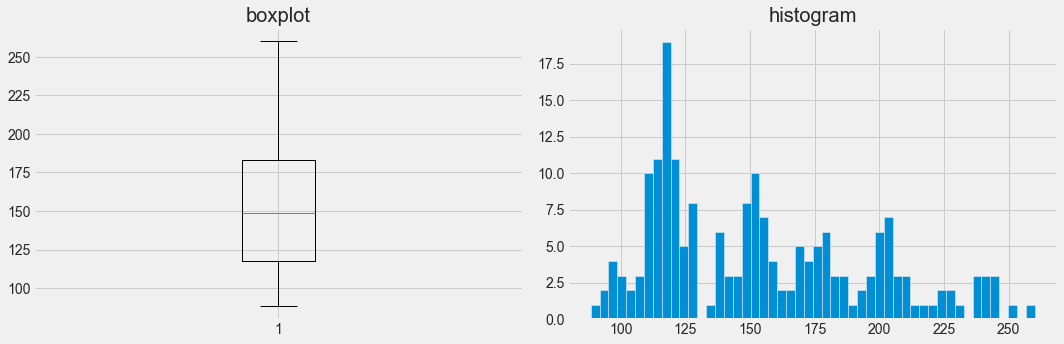

--------------------------------------------------------------------------------------------------------------
Plots for column: MDVP:Fhi(Hz)


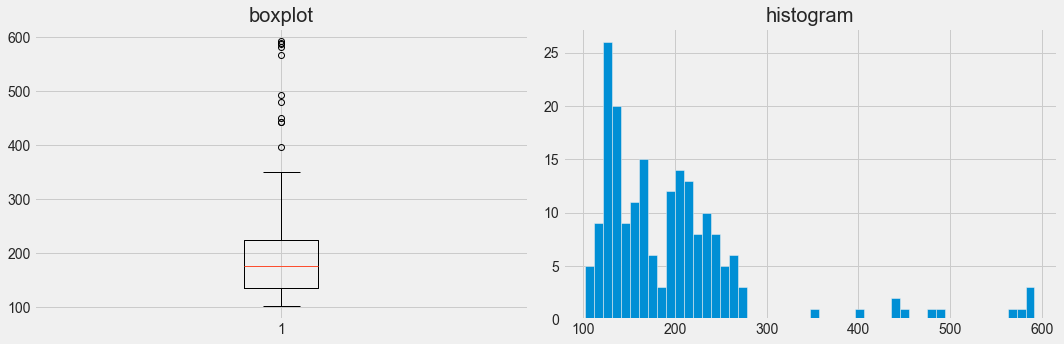

--------------------------------------------------------------------------------------------------------------
Plots for column: MDVP:Flo(Hz)


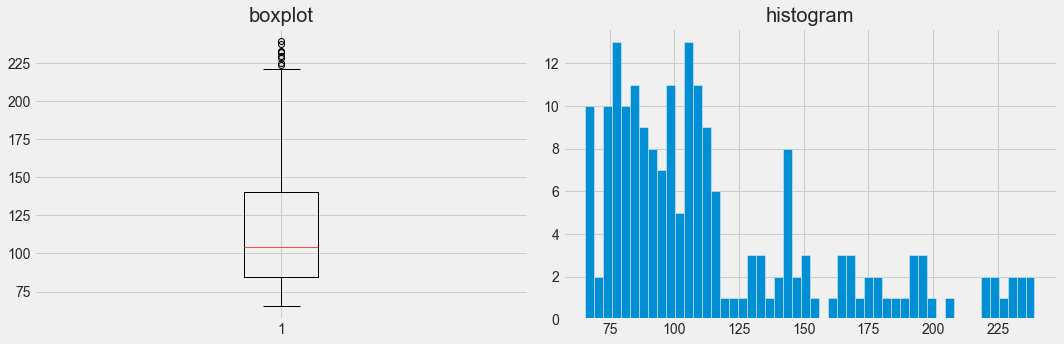

--------------------------------------------------------------------------------------------------------------
Plots for column: MDVP:Jitter(%)


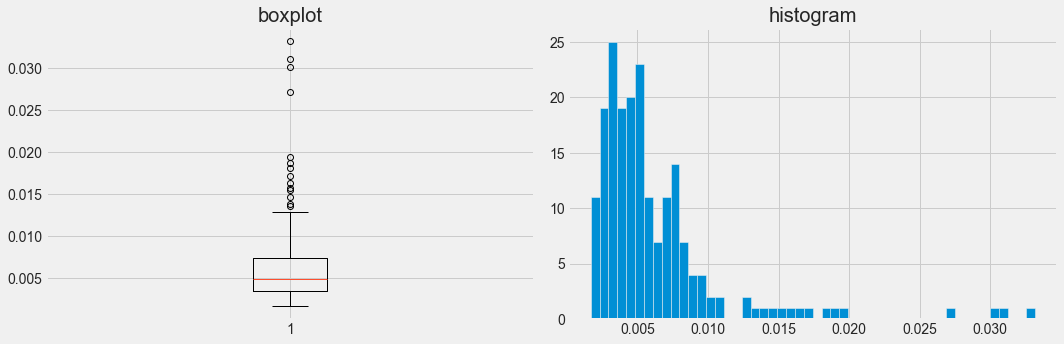

--------------------------------------------------------------------------------------------------------------
Plots for column: MDVP:Jitter(Abs)


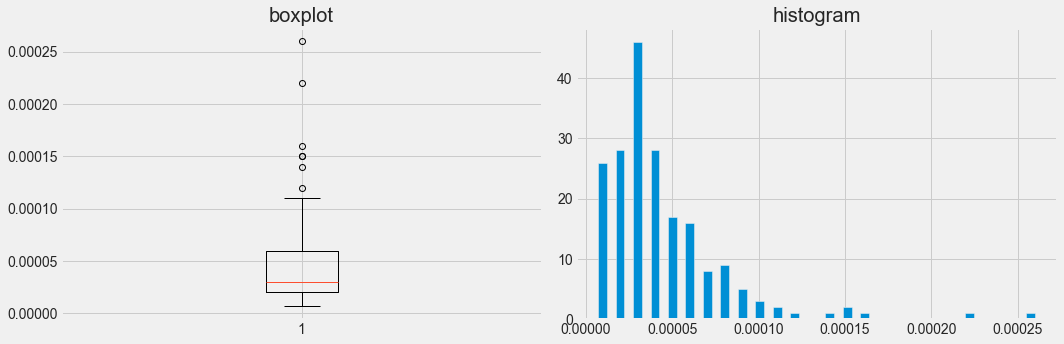

--------------------------------------------------------------------------------------------------------------
Plots for column: MDVP:RAP


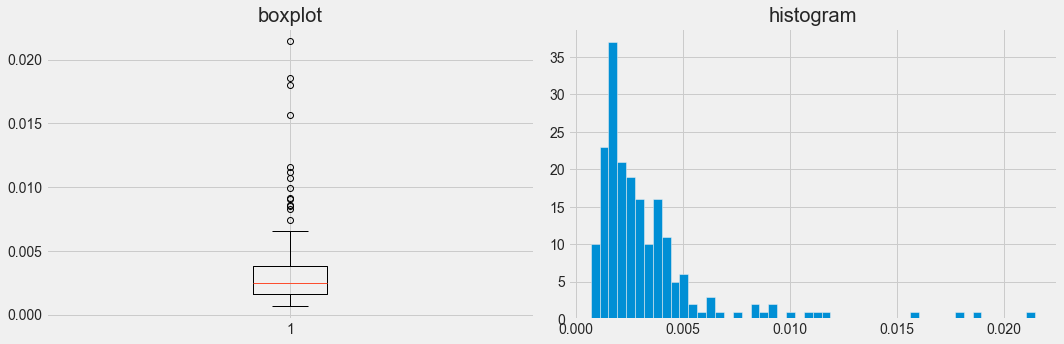

--------------------------------------------------------------------------------------------------------------
Plots for column: MDVP:PPQ


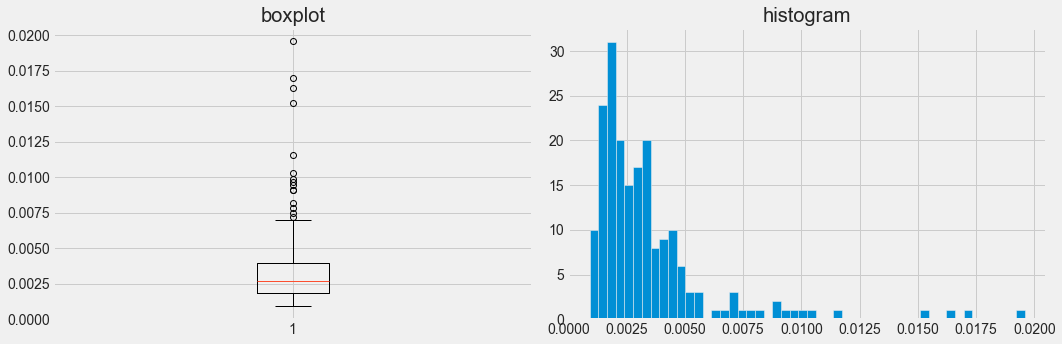

--------------------------------------------------------------------------------------------------------------
Plots for column: Jitter:DDP


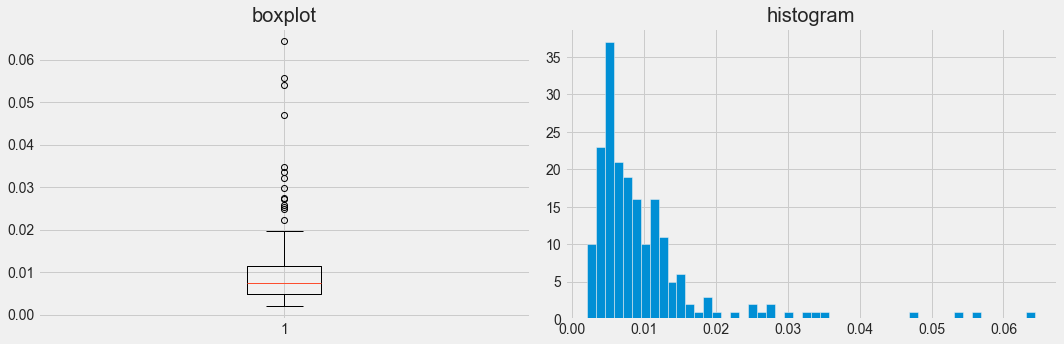

--------------------------------------------------------------------------------------------------------------
Plots for column: MDVP:Shimmer


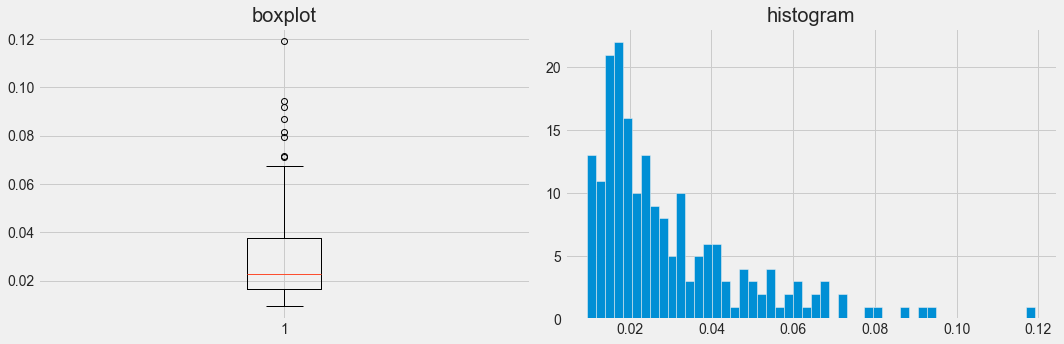

--------------------------------------------------------------------------------------------------------------
Plots for column: MDVP:Shimmer(dB)


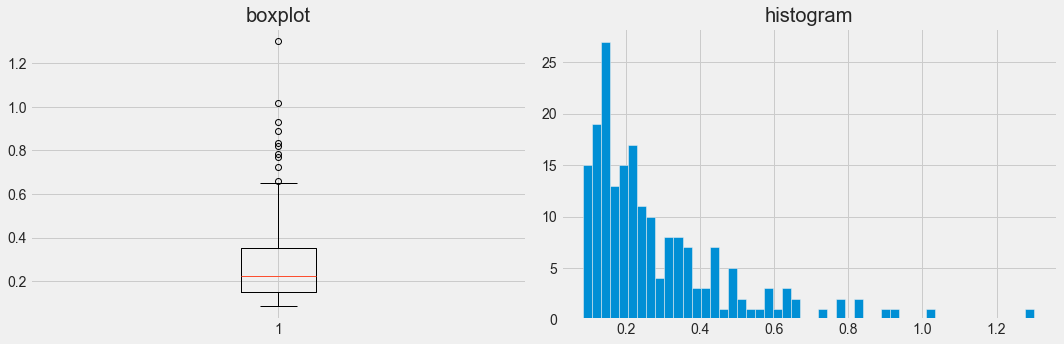

--------------------------------------------------------------------------------------------------------------
Plots for column: Shimmer:APQ3


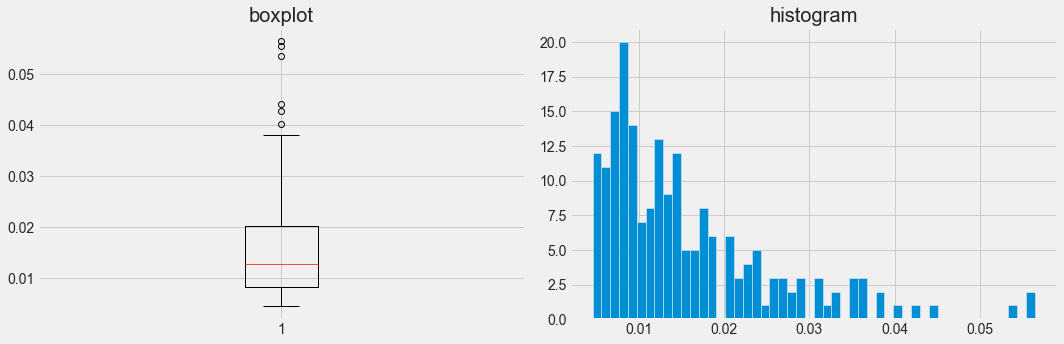

--------------------------------------------------------------------------------------------------------------
Plots for column: Shimmer:APQ5


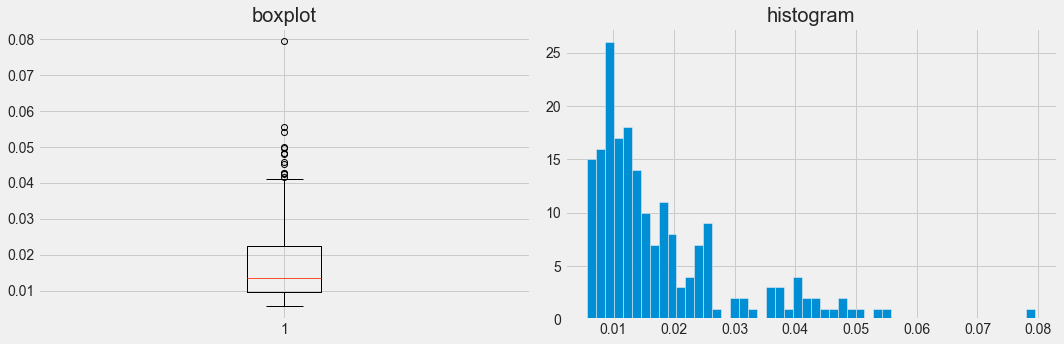

--------------------------------------------------------------------------------------------------------------
Plots for column: MDVP:APQ


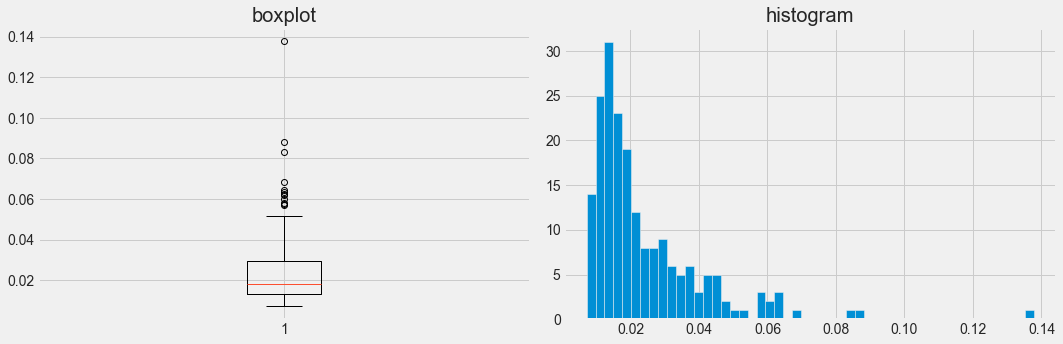

--------------------------------------------------------------------------------------------------------------
Plots for column: Shimmer:DDA


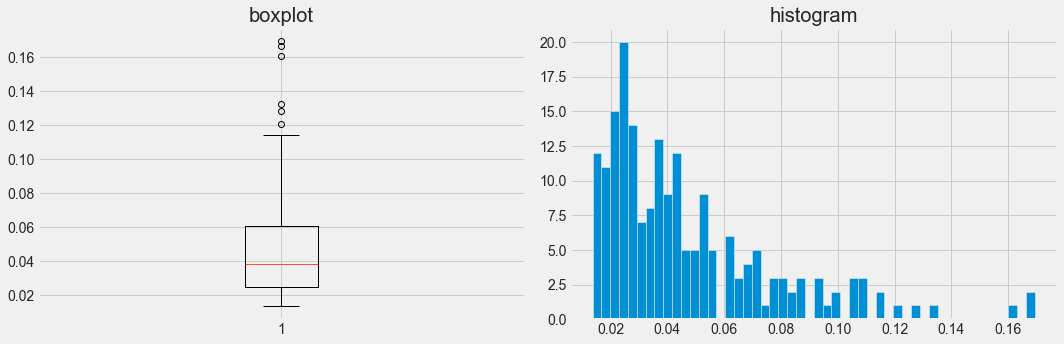

--------------------------------------------------------------------------------------------------------------
Plots for column: NHR


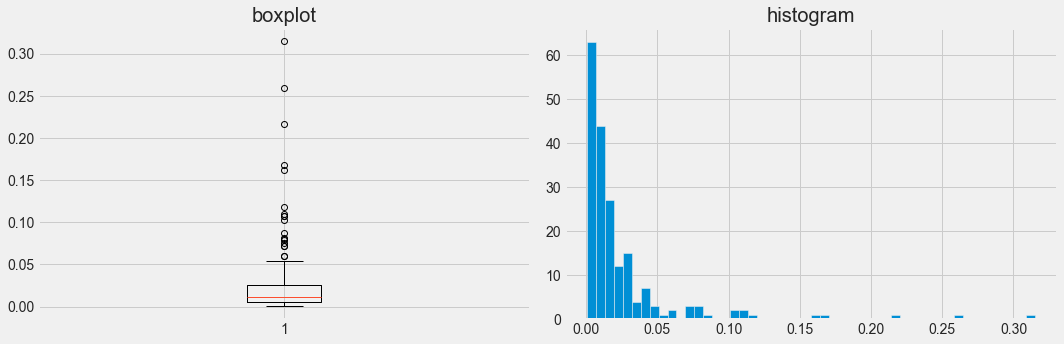

--------------------------------------------------------------------------------------------------------------
Plots for column: HNR


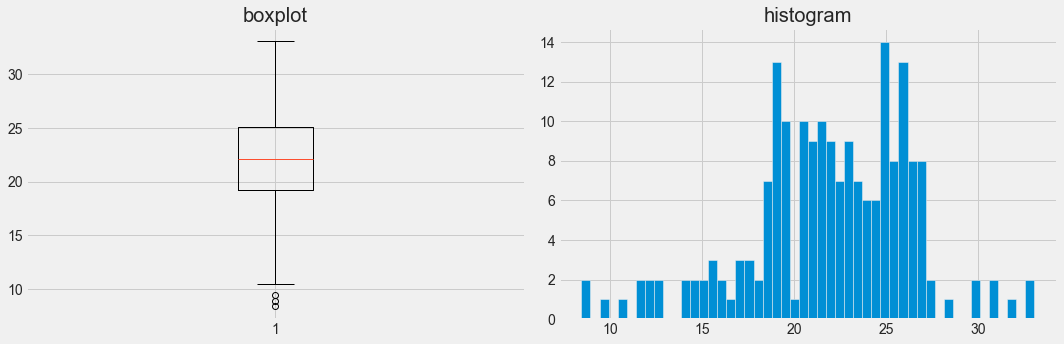

--------------------------------------------------------------------------------------------------------------
Plots for column: RPDE


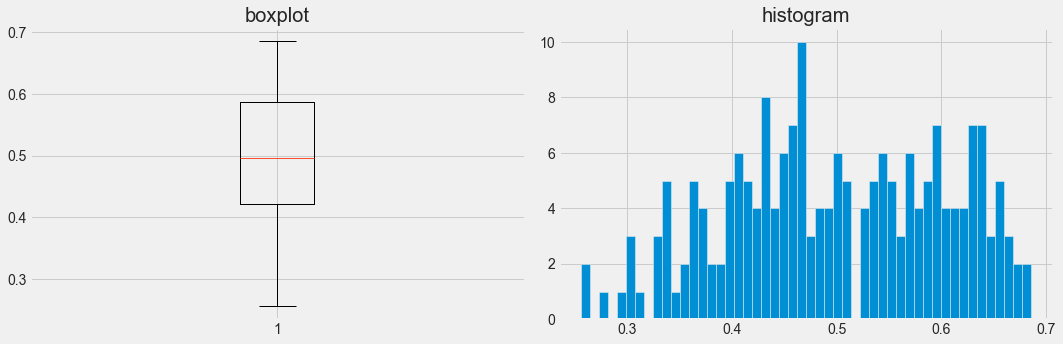

--------------------------------------------------------------------------------------------------------------
Plots for column: DFA


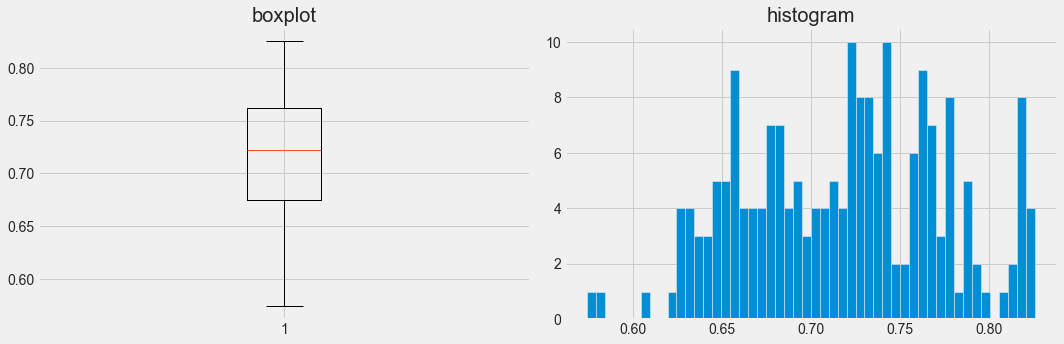

--------------------------------------------------------------------------------------------------------------
Plots for column: spread1


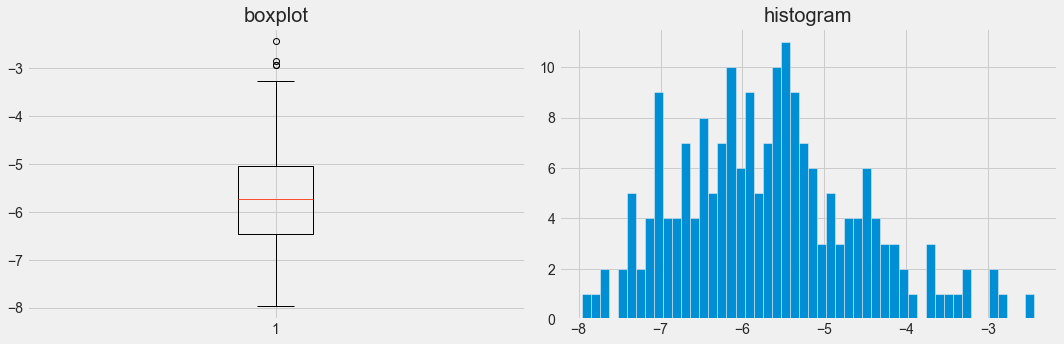

--------------------------------------------------------------------------------------------------------------
Plots for column: spread2


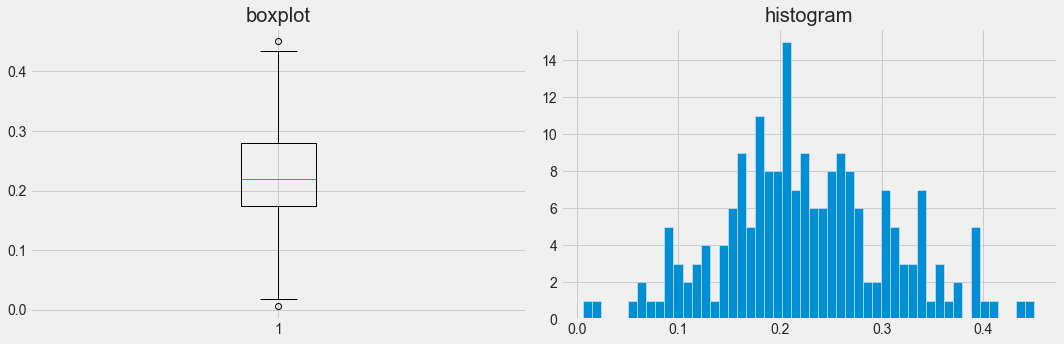

--------------------------------------------------------------------------------------------------------------
Plots for column: D2


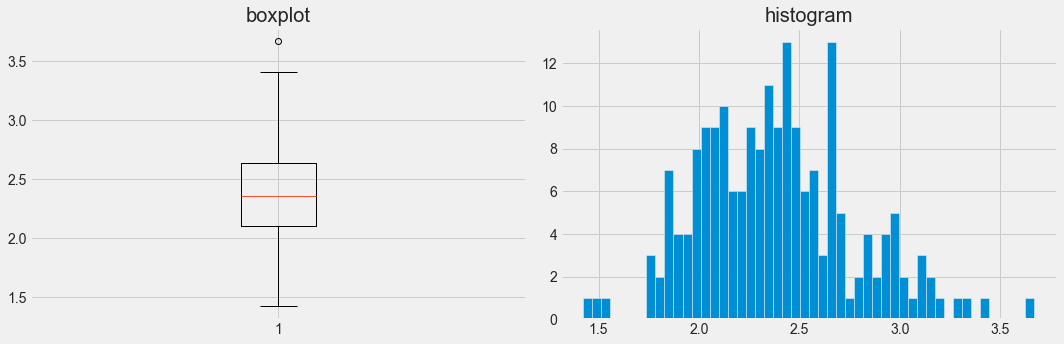

--------------------------------------------------------------------------------------------------------------
Plots for column: PPE


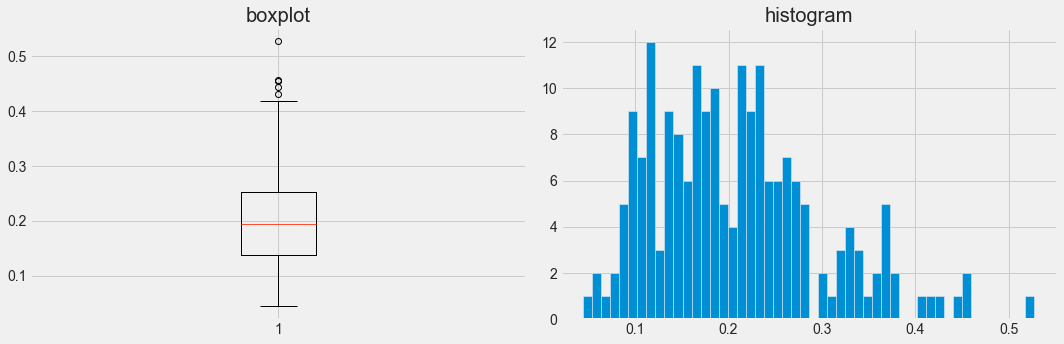

--------------------------------------------------------------------------------------------------------------


In [56]:
# df_analysis.plot(kind='box',figsize=(15,10)
sns.set_style("darkgrid")
plt.style.use('fivethirtyeight')
df1=df_analysis.select_dtypes(exclude=['object'])
for column in df1.columns:
    print(f'Plots for column: {column}')
    
    sigma = 1
    mu = 0
    fig, axes = plt.subplots(1,2,figsize=(15,5))
    ax1= axes[0]
    ax2= axes[1]
    ax1.boxplot(df_analysis[column])
    ax2.hist(df_analysis[column], bins=50)
    ax1.set_title('boxplot')
    ax2.set_title('histogram')
    
    plt.tight_layout()
    plt.show()
    print("--------------------------------------------------------------------------------------------------------------")
    
#     plt.figure(figsize=(17,1))
#     sns.boxplot(data=df1, x=column)

In [59]:
df_analysis.columns

Index(['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
       'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
       'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'spread1',
       'spread2', 'D2', 'PPE'],
      dtype='object')

<AxesSubplot:>

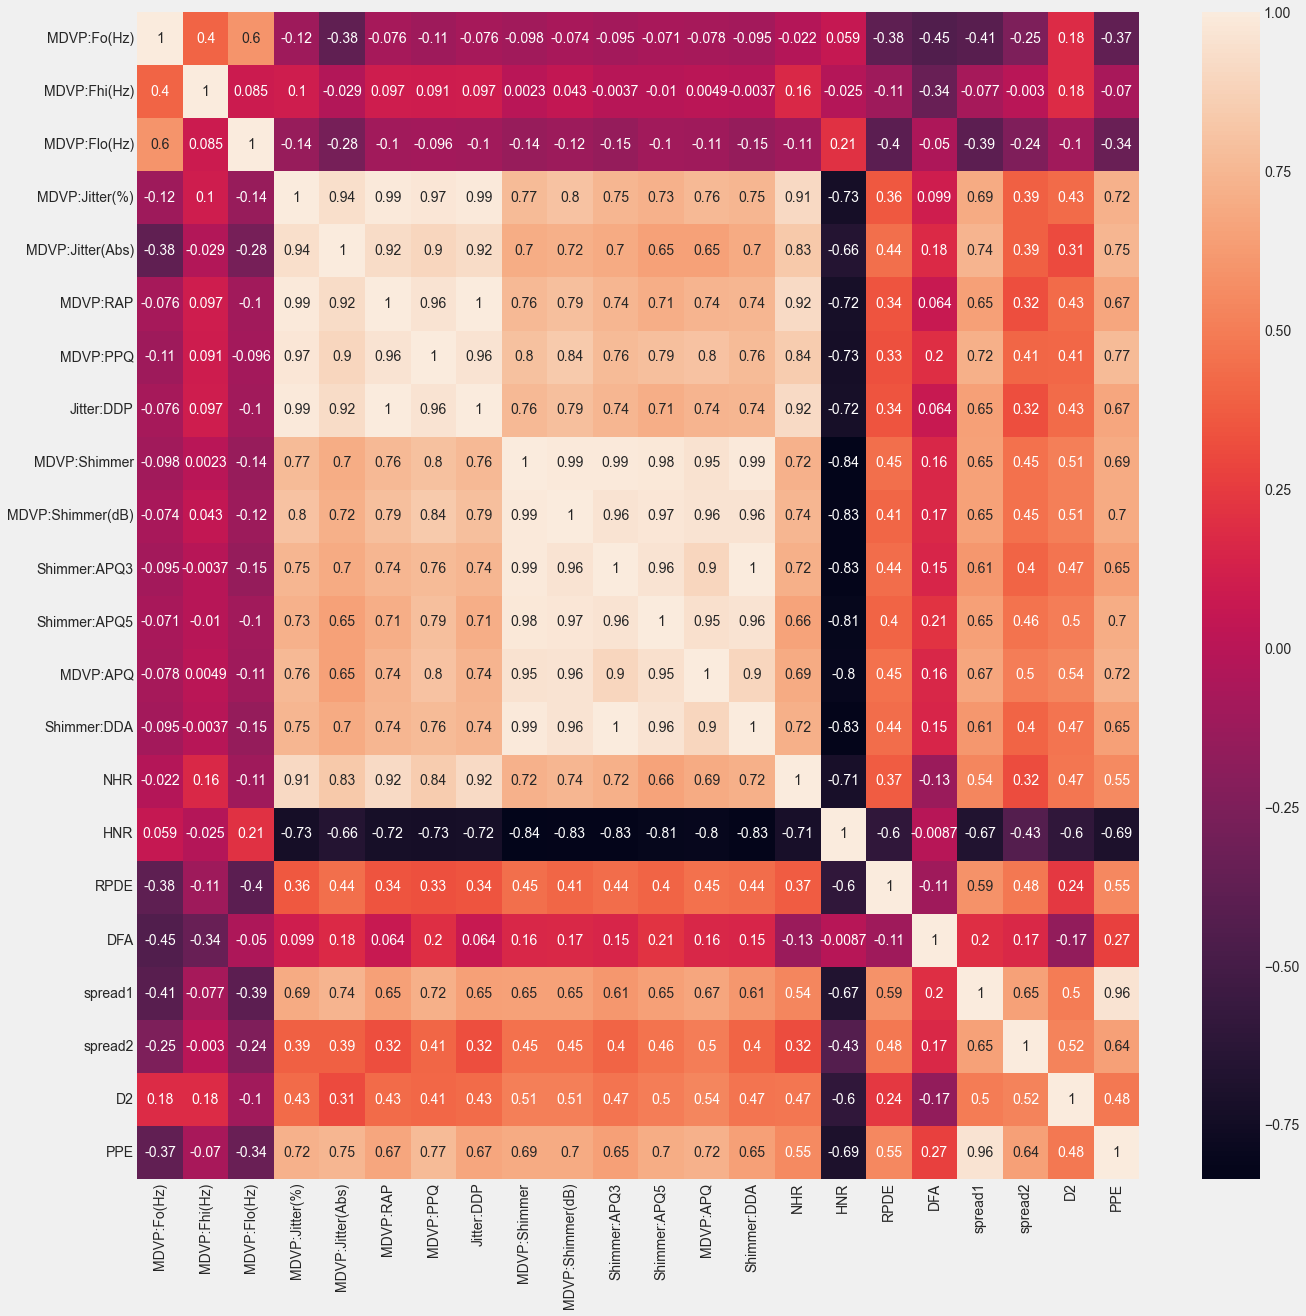

In [60]:
corrMatrix = df_analysis.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corrMatrix,annot=True)

In [63]:
features = ['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
       'MDVP:Shimmer', 'RPDE', 'DFA','spread2', 'D2', 'PPE']

In [65]:
df_final = df[features]

<AxesSubplot:>

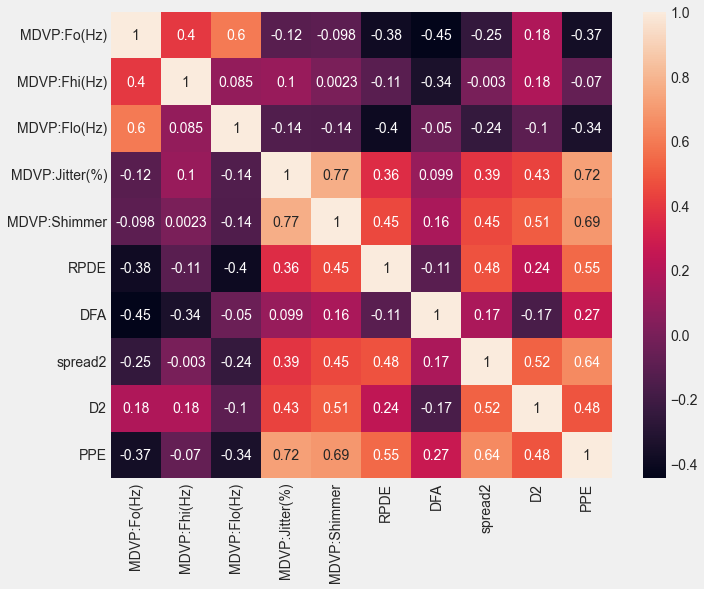

In [68]:
corrMatrix_final = df_final.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corrMatrix_final,annot=True)

In [69]:
df_final

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Shimmer,RPDE,DFA,spread2,D2,PPE
0,119.992,157.302,74.997,0.00784,0.04374,0.414783,0.815285,0.266482,2.301442,0.284654
1,122.400,148.650,113.819,0.00968,0.06134,0.458359,0.819521,0.335590,2.486855,0.368674
2,116.682,131.111,111.555,0.01050,0.05233,0.429895,0.825288,0.311173,2.342259,0.332634
3,116.676,137.871,111.366,0.00997,0.05492,0.434969,0.819235,0.334147,2.405554,0.368975
4,116.014,141.781,110.655,0.01284,0.06425,0.417356,0.823484,0.234513,2.332180,0.410335
...,...,...,...,...,...,...,...,...,...,...
190,174.188,230.978,94.261,0.00459,0.04087,0.448439,0.657899,0.121952,2.657476,0.133050
191,209.516,253.017,89.488,0.00564,0.02751,0.431674,0.683244,0.129303,2.784312,0.168895
192,174.688,240.005,74.287,0.01360,0.02308,0.407567,0.655683,0.158453,2.679772,0.131728
193,198.764,396.961,74.904,0.00740,0.02296,0.451221,0.643956,0.207454,2.138608,0.123306


In [74]:
#Modelling

In [75]:
from sklearn.model_selection import train_test_split

In [70]:
X = df_final.values

In [72]:
Y = df['status']

In [77]:
X_train, X_val, y_train, y_val = train_test_split(X,Y, train_size=0.8)

In [78]:
#Logistic regression
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
print("score on test: " + str(lr.score(X_val, y_val)))
print("score on train: "+ str(lr.score(X_train, y_train)))

score on test: 0.7435897435897436
score on train: 0.8910256410256411


In [79]:
#Naive Bayes multinomial
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB().fit(X_train, y_train)
print("score on test: " + str(mnb.score(X_val, y_val)))
print("score on train: "+ str(mnb.score(X_train, y_train)))

score on test: 0.6666666666666666
score on train: 0.5705128205128205


In [80]:
#KNN model
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(algorithm = 'brute', n_jobs=-1)
knn.fit(X_train, y_train)

print("score on test: " + str(knn.score(X_val, y_val)))
print("score on train: "+ str(knn.score(X_train, y_train)))

score on test: 0.6923076923076923
score on train: 0.8910256410256411


In [81]:
#SVM Model
from sklearn.svm import LinearSVC

svm=LinearSVC(C=0.0002)
svm.fit(X_train, y_train)

print("score on test: " + str(svm.score(X_val, y_val)))
print("score on train: "+ str(svm.score(X_train, y_train)))

score on test: 0.6666666666666666
score on train: 0.7756410256410257


In [83]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

print("score on test: " + str(clf.score(X_val, y_val)))
print("score on train: "+ str(clf.score(X_train, y_train)))

score on test: 0.8974358974358975
score on train: 1.0


In [84]:
#Bagging with DecisionTree
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
# max_samples: maximum size 0.5=50% of each sample taken from the full dataset
# max_features: maximum of features 1=100% taken here all 10K 
# n_estimators: number of decision trees 
bg=BaggingClassifier(DecisionTreeClassifier(),max_samples=0.5,max_features=1.0,n_estimators=10)
bg.fit(X_train, y_train)
print("score on test: " + str(bg.score(X_val, y_val)))
print("score on train: "+ str(bg.score(X_train, y_train)))

score on test: 0.8205128205128205
score on train: 0.9230769230769231


In [85]:
#AdaBoost with DecisionTree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
adb = AdaBoostClassifier(DecisionTreeClassifier(min_samples_split=10,max_depth=4),n_estimators=10,learning_rate=0.6)
adb.fit(X_train, y_train)
print("score on test: " + str(adb.score(X_val, y_val)))
print("score on train: "+ str(adb.score(X_train, y_train)))

score on test: 0.8461538461538461
score on train: 1.0


In [86]:
#Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
# n_estimators = number of decision trees
rf = RandomForestClassifier(n_estimators=30, max_depth=9)
rf.fit(X_train, y_train)
print("score on test: " + str(rf.score(X_val, y_val)))
print("score on train: "+ str(rf.score(X_train, y_train)))

score on test: 0.7948717948717948
score on train: 0.9935897435897436


In [88]:
from keras import layers
from keras import models
from keras import optimizers
from keras import losses
from keras import metrics

model=models.Sequential()
model.add(layers.Dense(16,activation='relu',input_shape=(10,)))
model.add(layers.Dense(16,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])
model.fit(X_train,y_train,epochs=50,batch_size=16,validation_data=(X_val,y_val))
print("score on test: " + str(model.evaluate(X_val,y_val)[1]))
print("score on train: "+ str(model.evaluate(X_train,y_train)[1]))

Epoch 1/50
10/10 [==============================] - 4s 38ms/step - loss: 12.1868 - accuracy: 0.3333 - val_loss: 6.0233 - val_accuracy: 0.3846
Epoch 2/50
10/10 [==============================] - 0s 10ms/step - loss: 2.7636 - accuracy: 0.6538 - val_loss: 4.0865 - val_accuracy: 0.5641
Epoch 3/50
10/10 [==============================] - 0s 9ms/step - loss: 2.0605 - accuracy: 0.6795 - val_loss: 2.7242 - val_accuracy: 0.5897
Epoch 4/50
10/10 [==============================] - 0s 6ms/step - loss: 1.3770 - accuracy: 0.6603 - val_loss: 1.6534 - val_accuracy: 0.6410
Epoch 5/50
10/10 [==============================] - 0s 5ms/step - loss: 1.1022 - accuracy: 0.6667 - val_loss: 1.4521 - val_accuracy: 0.6923
Epoch 6/50
10/10 [==============================] - 0s 6ms/step - loss: 0.8844 - accuracy: 0.7308 - val_loss: 2.1872 - val_accuracy: 0.6667
Epoch 7/50
10/10 [==============================] - 0s 6ms/step - loss: 0.8899 - accuracy: 0.6987 - val_loss: 1.1748 - val_accuracy: 0.7179
Epoch 8/50
10/10 

In [94]:
#Xtreme Gradient Boosting Algorithm
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
print("score on test: " + str(xgb.score(X_val, y_val)))
print("score on train: "+ str(xgb.score(X_train, y_train)))

[00:21:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
score on test: 0.8205128205128205
score on train: 1.0
